In [1]:
using JLD2
using FourierFlows
using Printf
using StatsBase
using CairoMakie
include("../AnalysisUtils.jl")

mapfilter_snapshots (generic function with 1 method)

In [2]:
#run_directory = "/scratch/nad9961/swqg/64977428/5"
run_directory = "/scratch/nad9961/swqg/66287753/1" # Frozen flow field with vortex merger
#run_directory = "/scratch/nad9961/swqg/66287753/2" # Frozen flow field without vortex merger
f0, Cg = read_parameters(run_directory)
nx, Lx = get_grid_size(run_directory, "swqg")
grid = TwoDGrid(; nx, Lx)

TwoDimensionalGrid
  ├───────────────── Device: CPU
  ├────────────── FloatType: Float64
  ├────────── size (Lx, Ly): (6.2831854820251465, 6.2831854820251465)
  ├──── resolution (nx, ny): (512, 512)
  ├── grid spacing (dx, dy): (0.012271846644580364, 0.012271846644580364)
  ├───────────────── domain: x ∈ [-3.1415927410125732, 3.129320894367993]
  |                          y ∈ [-3.1415927410125732, 3.129320894367993]
  └─ aliased fraction: 0.3333333333333333

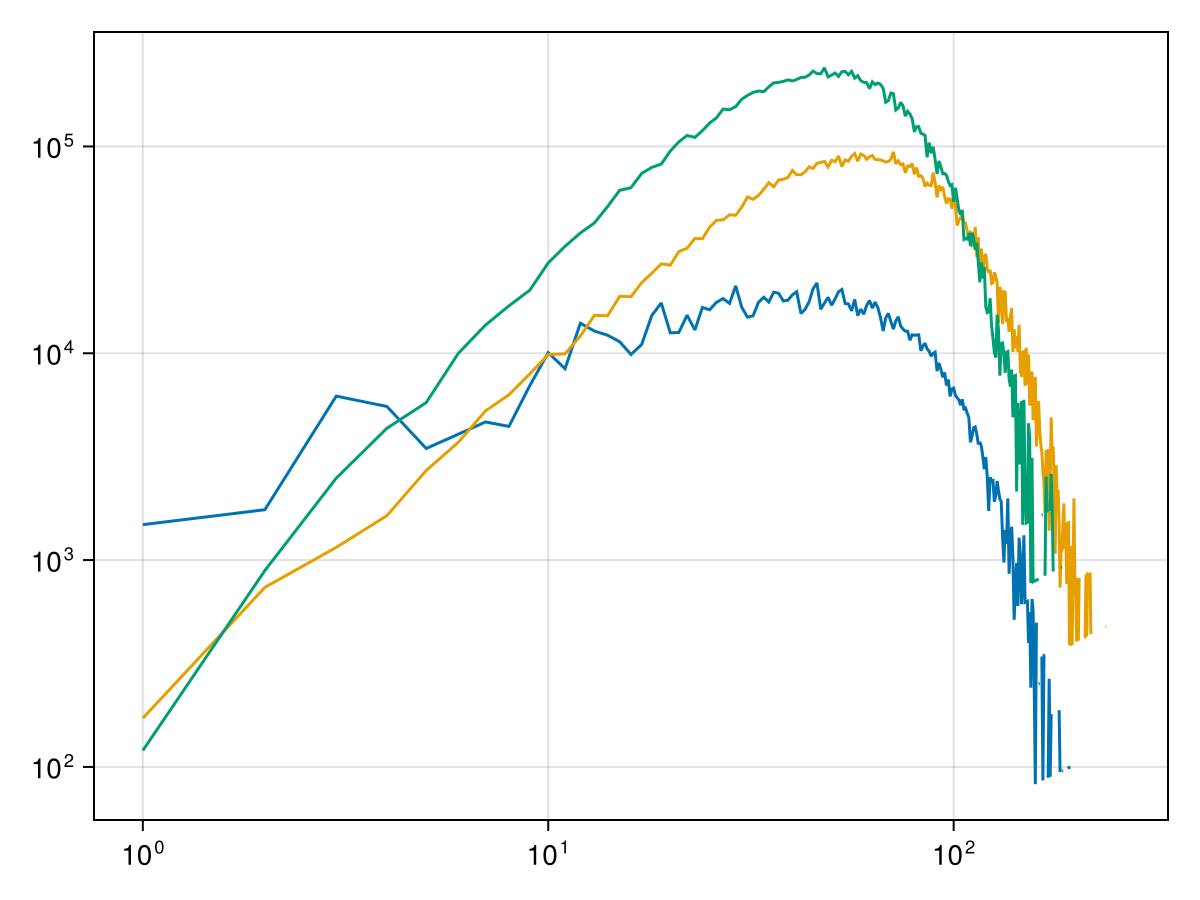

In [3]:
fig = Figure()
ax = Axis(fig[1,1]; xscale=log10, yscale=log10)

for idx=1:3
    run_directory = "/scratch/nad9961/swqg/66165430/" * string(idx)
    Nsnapshots = count_snapshots(run_directory)
    f0, Cg = read_parameters(run_directory)
    t, k, x, u = load_snapshot(run_directory, Nsnapshots)
    ω = compute_ω(k, f0, Cg)
    ω = ω[isfinite.(ω)]
    hist = fit(Histogram, ω, nbins=250)
    #plot(hist.weights)
    lines!(ax, replace(hist.weights .* hist.edges[1][2:end], 0.0 => NaN))
end
fig

In [3]:

Nsnapshots = count_snapshots(run_directory)
Npackets = 2
times = zeros(Nsnapshots)
xs = zeros(Npackets, Nsnapshots, 2)
ωs = zeros(Npackets, Nsnapshots)
Ωs = zeros(Npackets, Nsnapshots)
packet_idx = 1238:1239
idx = 1
for file_idx=1:100
    file = jldopen(@sprintf("%s/packets.%06d.jld2", run_directory, file_idx), "r")
    for key=keys(file["p/t"])
        times[idx] = file["p/t/"*key]
        xs[:,idx,:] = file["p/x/"*key][packet_idx,:]
        k = file["p/k/"*key][packet_idx,1]
        l = file["p/k/"*key][packet_idx,2]
        u = file["p/u/"*key][packet_idx,1]
        v = file["p/u/"*key][packet_idx,2]
        ωs[:, idx] = sqrt.(f0^2 .+ Cg^2*(k.^2 + l.^2))
        Ωs[:, idx] = ωs[:, idx] + k.*u + l.*v
        idx += 1
    end
    close(file)
end

In [14]:
Okubo_Weiss = zeros(Npackets, Nsnapshots)
idx = 1
for file_idx=1:100
    file = jldopen(@sprintf("%s/packets.%06d.jld2", run_directory, file_idx), "r")
    for key=keys(file["p/g"])
        ux = file["p/g/"*key][packet_idx, 1]
        uy = file["p/g/"*key][packet_idx, 2]
        vx = file["p/g/"*key][packet_idx, 3]
        vy = file["p/g/"*key][packet_idx, 4]
        σn = ux - vy
        σs = vx + uy
        ζ  = vx - uy
        Okubo_Weiss[:, idx] = @. σn.^2 + σs.^2 - ζ.^2
        idx += 1
    end
    close(file)
end

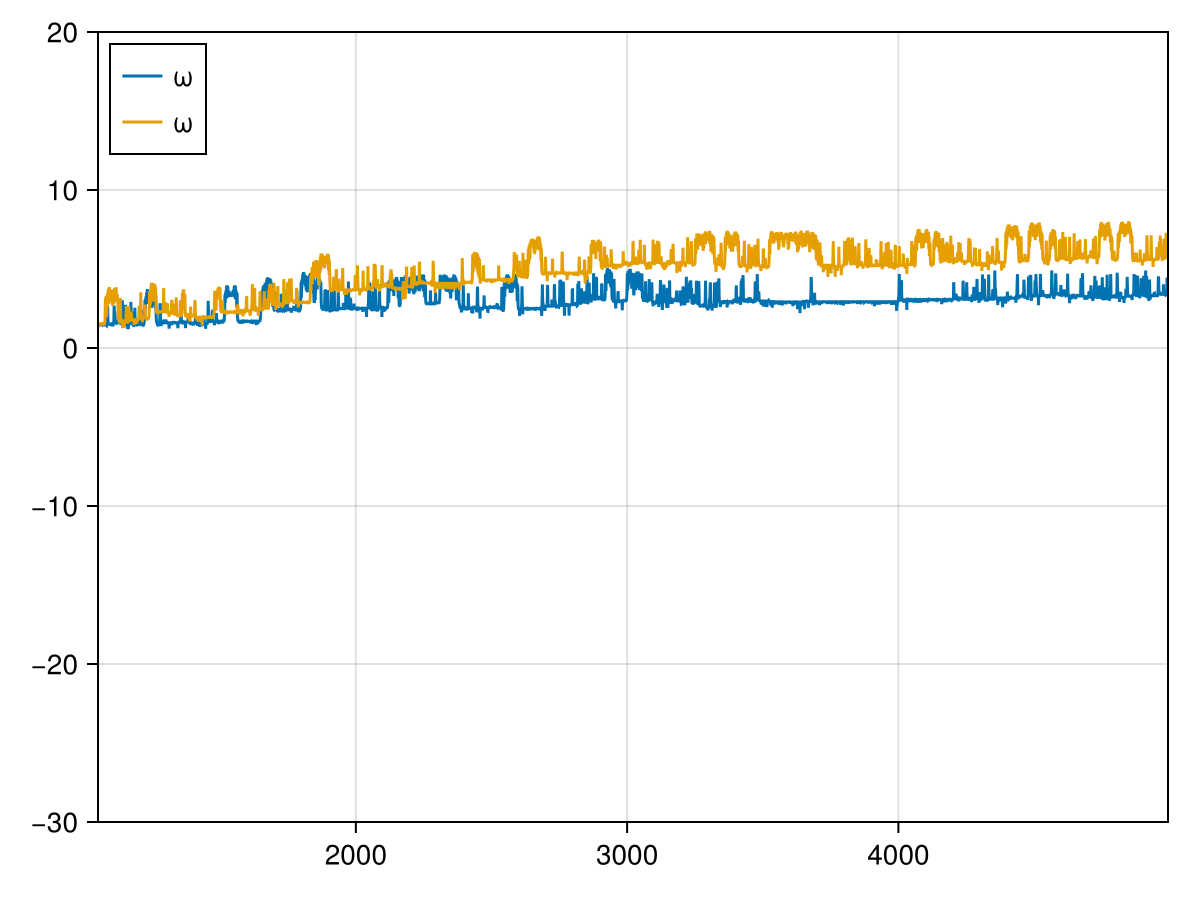

In [5]:
using CairoMakie

fig = Figure()
idx = 4000
ax = Axis(fig[1,1], limits=((times[2], times[idx-1]), (-30, 20)))
for i=1:Npackets
    #lines!(ax, times[2:idx-1], Okubo_Weiss[i, 2:idx-1], label="Okubo Weiss")
    lines!(ax, times[2:idx-1], log.(ωs[i, 2:idx-1]), label="ω")
    #lines!(ax, times[2:idx-1], log.(abs.(Ωs[i, 2:idx-1])), label="Ω")
end

axislegend(ax, position=:lt)

fig

In [16]:
mod_xs = mod.((xs .- grid.x[1]), grid.Lx) .+ grid.x[1]

2×9671×2 Array{Float64, 3}:
[:, :, 1] =
 0.308805   1.05469      1.80866   …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.349494  -0.00388861  -0.347155     0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 -2.52078  -2.65832  -2.78767   …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  1.97678   1.25915   0.537274     0.0  0.0  0.0  0.0  0.0  0.0  0.0

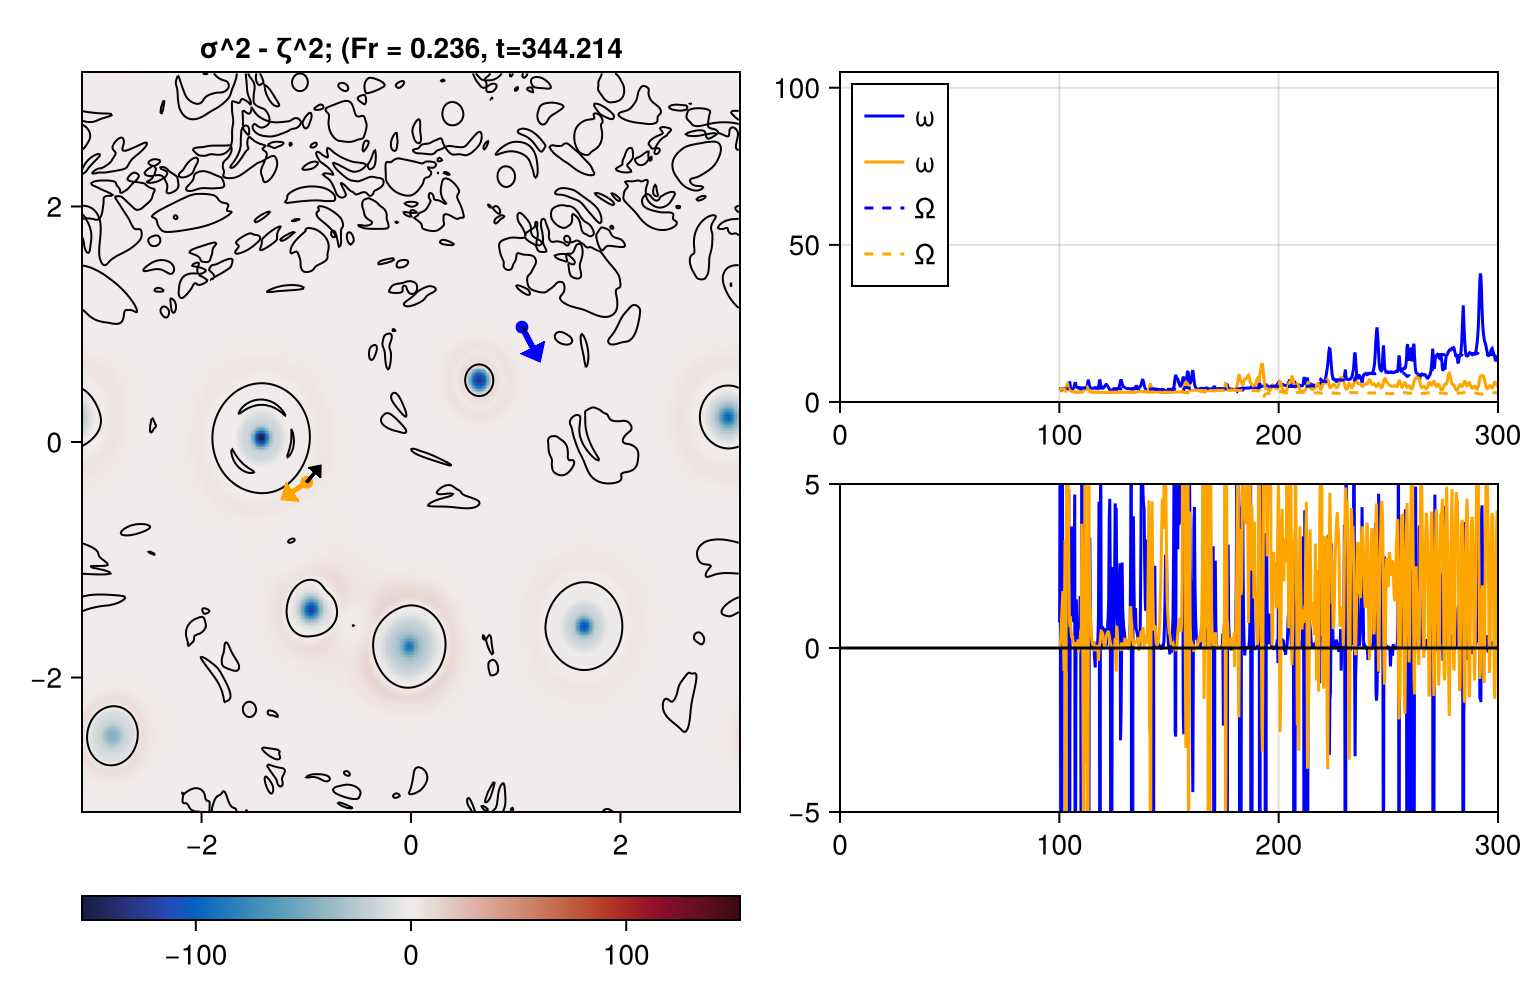

In [27]:
run_directory = "/scratch/nad9961/swqg/66161250/1"
#run_directory = "/scratch/nad9961/swqg/64977428/5"
#run_directory = "/scratch/nad9961/swqg/66287753/1" # Frozen flow field with vortex merger
#run_directory = "/scratch/nad9961/swqg/66287753/2" # Frozen flow field without vortex merger

disp_rel(k, l) = sqrt.(f0^2 + Cg^2*(k^2 + l^2))
Cg_x(k, l, sign) = Cg*k/disp_rel(k, l) * sign
Cg_y(k, l, sign) = Cg*l/disp_rel(k, l) * sign
temp = ones(grid.nx, grid.ny)
ζ =  Observable(temp)
xs = Observable([0.0, 0.0])
ys = Observable([0.0, 0.0])
Cgxs = Observable([0.0, 0.0])
Cgys = Observable([0.0, 0.0])
us = Observable([0.0, 0.0])
vs = Observable([0.0, 0.0])
ωs1 = Observable(Point2f[])
Ωs1 = Observable(Point2f[])
ωs2 = Observable(Point2f[])
Ωs2 = Observable(Point2f[])
D21 = Observable(Point2f[])
D22 = Observable(Point2f[])
ζ_max = @lift maximum(abs.($ζ))
colorrange = @lift ((-$ζ_max, $ζ_max))
colors = [:blue, :orange]

fig = Figure(size=(800, 500))
Fr = Observable(0.0)
t  = Observable(0.0)
title=@lift @sprintf("σ^2 - ζ^2; (Fr = %0.3f, t=%0.3f", $Fr, $t)
real_ax = Axis(fig[1:2,1]; limits=((-π, π), (-π, π)), title=title)
freq_ax = Axis(fig[1,2]; limits=((0, 300), (0, 105)))
OW_ax   = Axis(fig[2,2]; limits=((0, 300), (-5, 5)))
f0, Cg, freq_sign = read_parameters(run_directory)
hm = heatmap!(real_ax, grid.x, grid.y, ζ; colormap=:balance, colorrange=colorrange)
Colorbar(fig[3,1], hm, vertical=false, flipaxis=false)
contour!(real_ax, grid.x, grid.y, ζ, levels=[0.0]; color=:black)
scatter!(real_ax, xs, ys, color=colors)
arrows2d!(real_ax, xs, ys, Cgxs, Cgys, color=colors, lengthscale=0.35)
arrows2d!(real_ax, xs, ys, us, vs, color=:black, lengthscale=0.35)
lines!(freq_ax, ωs1, color=:blue, linestyle=:solid, label="ω")
lines!(freq_ax, ωs2, color=:orange, linestyle=:solid, label="ω")
lines!(freq_ax, Ωs1, color=:blue, linestyle=:dash, label="Ω")
lines!(freq_ax, Ωs2, color=:orange, linestyle=:dash, label="Ω")
lines!(OW_ax, D21, color=:blue, linestyle=:solid, label="D")
lines!(OW_ax, D22, color=:orange, linestyle=:solid, label="D")
lines!(OW_ax, [0, 300], [0, 0], color=:black)
axislegend(freq_ax, position=:lt)
packet_factor = 1

colsize!(fig.layout, 1, Aspect(1, 2.0))
colsize!(fig.layout, 2, Aspect(1, 2.0))
resize_to_layout!(fig)
packet_idxs = [17884, 53320]
record(fig, "animation.mp4", 2:5:5000; framerate=10) do frame
    t[], qh, ψh, uh, vh, Kd2 = load_qgswh_snapshot(run_directory, grid, frame)
    tp, x, k, u, ug = load_snapshot(run_directory, frame, load_gradients=true)
    mod_x = mod.(x .- grid.x[1], grid.Lx) .+ grid.x[1]
    xs[] = mod_x[packet_idxs,1]
    ys[] = mod_x[packet_idxs,2]
    ks = k[packet_idxs,1]
    ls = k[packet_idxs,2]
    Cgxs[] = Cg_x.(ks, ls, freq_sign[packet_idxs])
    Cgys[] = Cg_y.(ks, ls, freq_sign[packet_idxs])
    us[] = u[packet_idxs,1]
    vs[] = u[packet_idxs,2]
    ux = ug[packet_idxs,1]
    uy = ug[packet_idxs,2]
    vx = ug[packet_idxs,3]
    vy = ug[packet_idxs,4]
    ζp = vx - uy
    σsp = vx + uy
    σnp = ux - vy
    D2 = σsp.^2 + σnp.^2 - ζp.^2
    ω = disp_rel.(ks, ls)
    dop = us[] .* ks + vs[] .* ls
    ωs1[] = push!(ωs1[], (tp, ω[1]))
    ωs2[] = push!(ωs2[], (tp, ω[2]))
    Ωs1[] = push!(Ωs1[], (tp, ω[1] + dop[1]))
    Ωs2[] = push!(Ωs2[], (tp, ω[2] + dop[2]))
    D21[] = push!(D21[], (tp, D2[1]))
    D22[] = push!(D22[], (tp, D2[2]))
    ζh = 1im*grid.kr.*vh - 1im*grid.l.*uh
    σnh = 1im*grid.kr.*uh - 1im*grid.l.*vh
    σsh = 1im*grid.kr.*vh + 1im*grid.l.*uh
    ζr = irfft(ζh, grid.nx)
    σn = irfft(σnh, grid.nx)
    σs = irfft(σsh, grid.nx)
    u = irfft(uh, grid.nx)
    v = irfft(vh, grid.nx)
    u_rms = sqrt.(sum(u.^2 + v.^2)/grid.nx/grid.ny)
    Fr[] = u_rms / Cg
    ζ[] = σn.^2 + σs.^2 - ζr.^2
end
fig

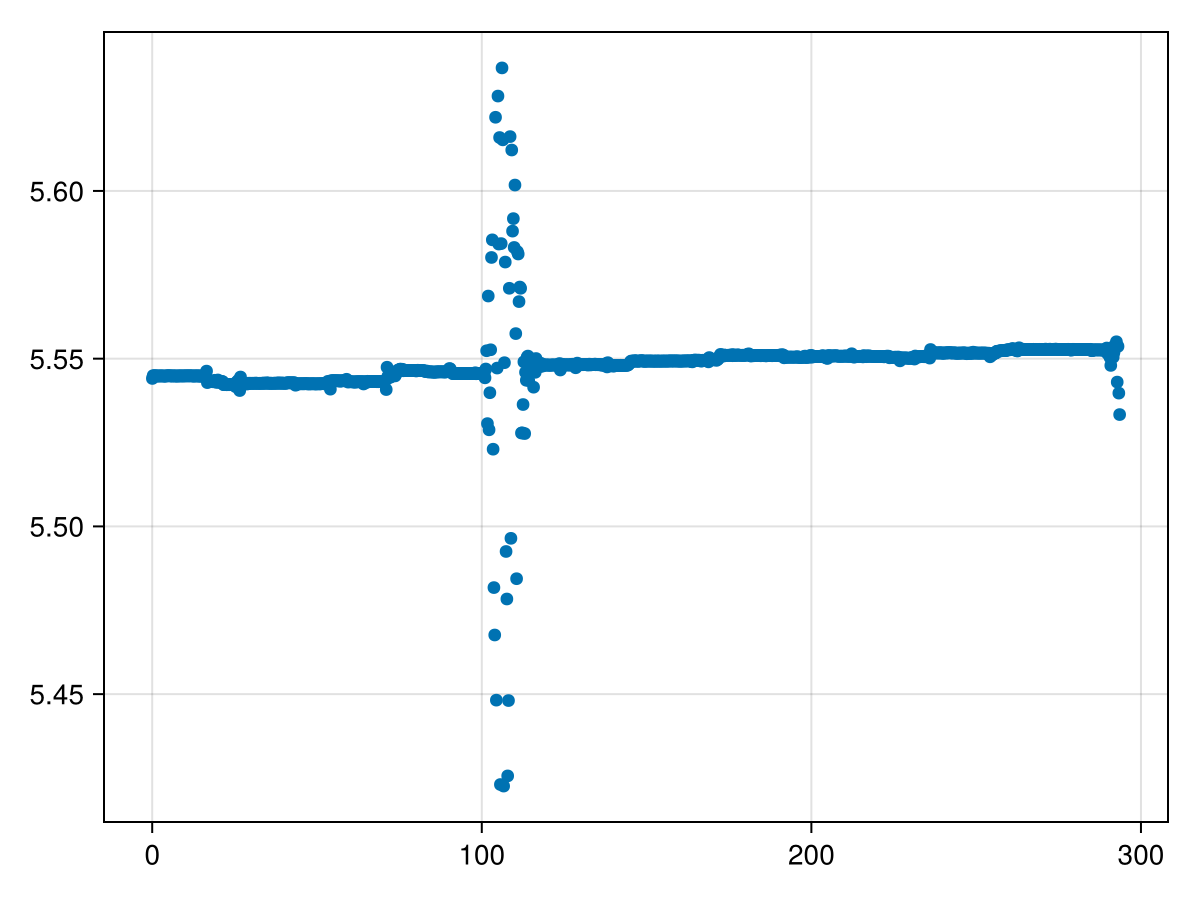

In [22]:
plot(Ωs1[])

In [23]:
run_directory = "/scratch/nad9961/swqg/66161250/1"
Nsnapshots = count_snapshots(run_directory)
tp, x, k, u = load_snapshot(run_directory, Nsnapshots, load_gradients=false)

(995.53265f0, Float32[-31.79518 -20.708284; 136.2998 -54.069763; … ; -189.97311 -62.44243; -27.091217 24.848658], Float32[-4.0343766 12.229222; 14.743752 2.074237; … ; -9.837359 37.253933; 0.8094955 2.5639412], Float32[-0.0033452963 -6.692042f-5; 0.0122870905 -0.02878462; … ; -0.00890265 0.013320537; 0.00058869284 0.0034320247])

In [26]:
I = argmax(sqrt.(f0^2 .+ sum(k.^2, dims=2)))
println(k[I[1], :], " ", I)

j = argmin(sqrt.(f0^2 .+ sum(k.^2, dims=2)))
println(k[j[1], :], " ", j)

println(Nsnapshots)

Float32[-422.0842, -276.07846] CartesianIndex(17884, 1)
Float32[-0.0049562594, -0.015682956] CartesianIndex(53320, 1)
18336


In [54]:
t1, _, = load_qgswh_snapshot(run_directory, grid, 2)
t2, _, = load_qgswh_snapshot(run_directory, grid, 3)
println(t1)
println(t2)
pt1, _, = load_snapshot(run_directory, 3*2-2)
pt2, _, = load_snapshot(run_directory, 3*3-2)
println(pt1)
println(pt2)
dpt = pt2 - pt1
dt = t2 - t1
println(dt / dpt)

992.33514
995.24396
992.33514
995.24396
1.0


In [108]:
4:500:8004

4:500:8004

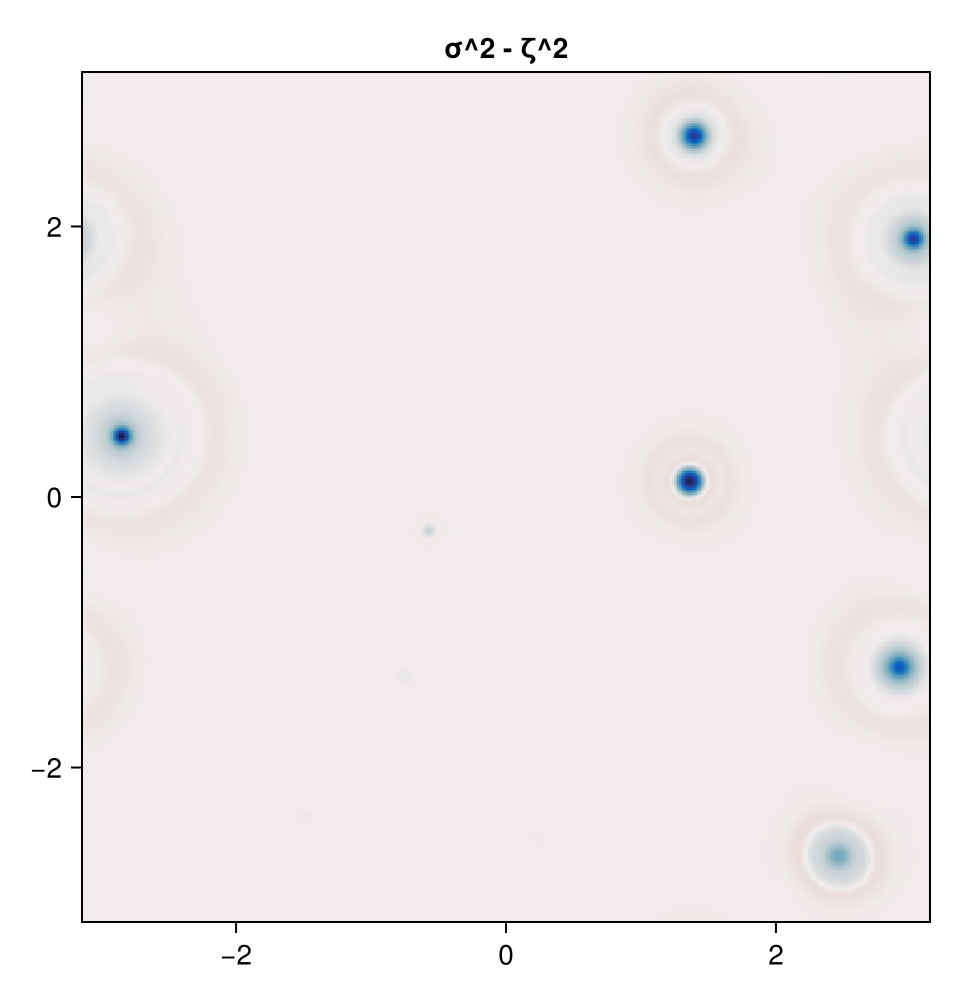

In [50]:
using CairoMakie
using FourierFlows
run_directory = "/scratch/nad9961/swqg/66165430/3"

fig = Figure(size=(800, 500))
ax = Axis(fig[1,1]; limits=((-π, π), (-π, π)), title="σ^2 - ζ^2")
f0, Cg, freq_sign = read_parameters(run_directory)
nx, Lx = get_grid_size(run_directory, "swqg")
grid = TwoDGrid(; nx, Lx)

t, qh, ψh, uh, vh, Kd2 = load_qgswh_snapshot(run_directory, grid, 8000)
ζh = 1im*grid.kr.*vh - 1im*grid.l.*uh
σnh = 1im*grid.kr.*uh - 1im*grid.l.*vh
σsh = 1im*grid.kr.*vh + 1im*grid.l.*uh
ζr = irfft(ζh, grid.nx)
σn = irfft(σnh, grid.nx)
σs = irfft(σsh, grid.nx)
D2 = σn.^2 + σs.^2 - ζr.^2
D2_max = maximum(abs.(D2))
heatmap!(ax, grid.x, grid.y, D2, colormap=:balance, colorrange=(-D2_max, D2_max))
colsize!(fig.layout, 1, Aspect(1, 1.0))
resize_to_layout!(fig)
fig

In [49]:
merger_directory = "/scratch/nad9961/swqg/66161250/1/swqg.000013.jld2"
merger_key = "snapshots/sol/344680"

normal_directory = "/scratch/nad9961/swqg/66161250/1/swqg.000016.jld2"
normal_key = "snapshots/sol/401480"

JLDFile /scratch/nad9961/swqg/66161250/1/swqg.000013.jld2 (read-only)
 └─📂 snapshots
    ├─📂 t
    │  ├─🔢 341480
    │  ├─🔢 341520
    │  ├─🔢 341560
    │  ├─🔢 341600
    │  ├─🔢 341640
    │  ├─🔢 341680
    │  └─ ⋯ (494 more entries)
    └─📂 sol (500 entries)

In [53]:
file

JLDFile /scratch/nad9961/swqg/66161250/1/swqg.000016.jld2 (read-only)
 └─📂 snapshots
    ├─📂 t
    │  ├─🔢 401480
    │  ├─🔢 401520
    │  ├─🔢 401560
    │  ├─🔢 401600
    │  ├─🔢 401640
    │  ├─🔢 401680
    │  └─ ⋯ (494 more entries)
    └─📂 sol (500 entries)